# Assignment 6.12: Final Assignment: Advanced Algorithms Design
Author: Manuela Profir

# Instructions
Final assignments

Follow the example from Bootcamp 4 for creating the quantum walk operator for the case of a circle with 4 nodes, and design the quantum walk operator for the case of a line with 16 nodes. 

A. Create a well-detailed Python Jupyter notebook that explains your algorithm, including the code parts covered in class, and pictures/figures where relevant. Utilize the Python code from class: quantum_walk_circle_example.py. It can be found directly also in the Classiq Git Library in the community/womanium/assignments. Feel free to extend the example beyond the requirements here and what was covered in class.


B. Contribute your notebook to the Classiq Git Library to the folder community/womanium/assignments 

# Implementation

In the case of a line topology, the nodes are disposed in a sequency, where each node is connected to its immediate left or right neighbors. In the case of our assignment, we consider a line of 16 nodes numbered from 0 to 15 and we move from the current node to an adjacent node with equal probability.

We define a quantum function for every step of the algorithm. Since we have to implement a quantum walk with a classical graph with 16 nodes/vertices, the size (the number of qubits to represent the vertices) will be 4 ($log_2(16)$).

In [1]:
from classiq import *

In [2]:
size = 4

We first proceed with the enconding step of the algorithm. We first prepare a qubit in the |-> state. 

In [3]:
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)

We define a diffuser oracle for Grover algorithm applied to an auxiliary qubit and to the QNum x which represents the node to check. 

In [4]:
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)

We define the phase kickback in the zero_diffuser quantum function applied to a quantum variable QNum x which represents the current node. We initialize another auxiliary qubit for the phase kickback primitive and the oracle is applied within the prepare_minus function which brings the auxilliary qubit into the minus state. 

In [5]:
@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

The core part of the quantum walk algorithm is the Evolution step applied on two unitary operators, W (also called C) and S. This step is applied iteratively on the quantum states defined previously in the encoding step. We define the W operator for the quantum walk which takes as arguments: 
i (int): the current node index, vertices (QNum): the vertices and adjacent_vertices (QNum): representing the adjacent vertices. By means of the W operator we determine the probabilities to move left or right from each node. The difusser oracle is used to amplify the probabilities of the adjacent nodes.

In [6]:
def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    if i == 0:
        prob[i + 1] = 1.0  # If at the first node, we move to the right node (node 1)
    elif i == 15:
        prob[i - 1] = 1.0  # If at the last node, we move to the left node (node 14)
    else:
        prob[i - 1] = 0.5  # Probability of moving to the left node
        prob[i + 1] = 0.5  # Probability of moving to the right node
    print(f"State={i}, prob vec ={prob}")
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


We now apply the W_operator to all the vertices.

In [7]:
@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)


We define an oracle to encode the edges. The oracle checks if two vertices are adjacent. It takes as arguments a qubit to store the result of the adjacency check, the vertices and the adjacent vertices.

In [8]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1)

We define the bitwise_swap function which swaps the values of two QArrays of qubits one by one.

In [9]:
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))

In the last part of the algorithm we define the S operator, which is meant to execute the effective displacement. In fact, it swaps vertices with their adjacent vertices according to the amplitudes set by the W operator. 

In [10]:
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))


Finally, we put all together into the main function to implement the required quantum walk. We initialize the vertices, we apply the Hadamard transform to have an equal superposition of the vertices, we allocate qubits for adjacent vertices and apply the two evolving operators. 

In [11]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

In [12]:
quantum_model = create_model(main)
qprog = synthesize(quantum_model)


State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

Running the model without any constraints, brings to an error saying that number of request qubits is 37 while the limit is 25. Therefore, the model is run with a constraint. The circuit is optimized by width. In fact, with this optimization parameter, the model runs well.   

In [13]:
quantum_model_with_constraints = set_constraints(quantum_model, Constraints(optimization_parameter="width", max_depth=5000))


In [14]:
quantum_program = synthesize(quantum_model_with_constraints)

In [15]:
circuit_width = QuantumProgram.from_qprog(quantum_program).data.width
circuit_depth = QuantumProgram.from_qprog(quantum_program).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth}")



The circuit width is 25 and the circuit_depth is 2317


In [16]:
show(quantum_program)
write_qmod(quantum_model, "Quantum walk_ManuelaProfir")


Opening: https://platform.classiq.io/circuit/285fb7ae-225a-4dbc-b6cc-3d5bbac20f5e?version=0.43.3


The circuit and the results are shown in the pictures below. 

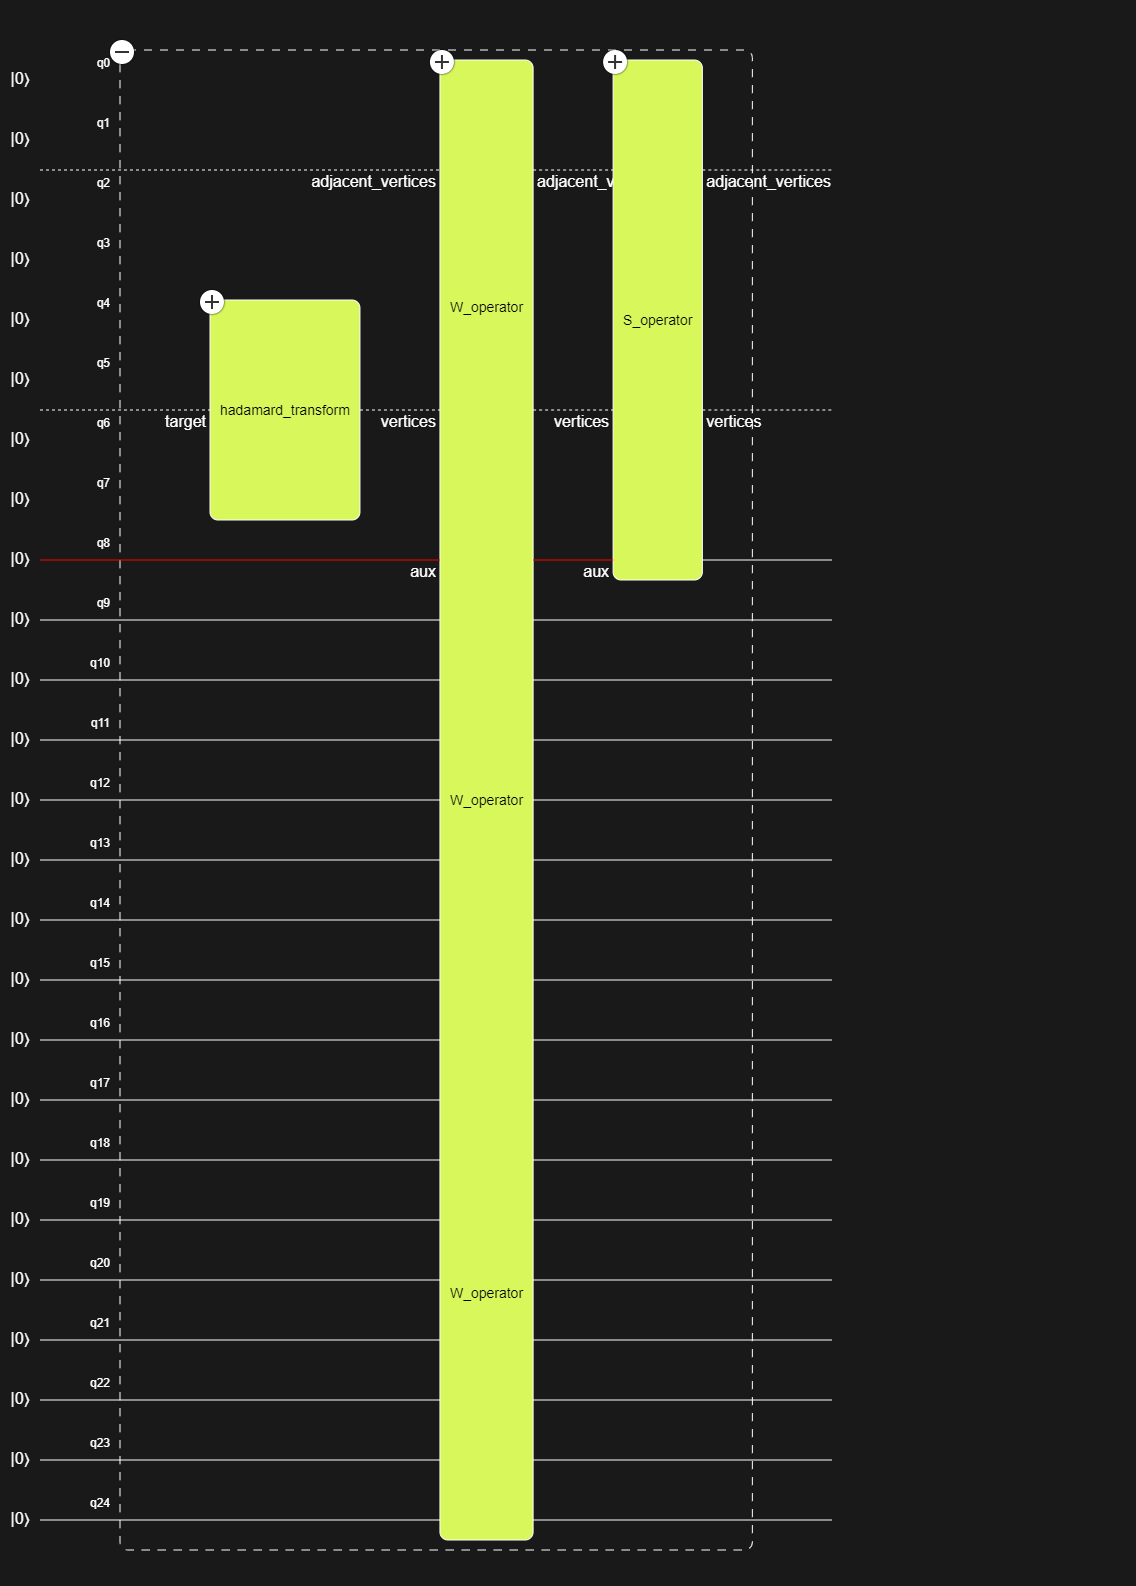


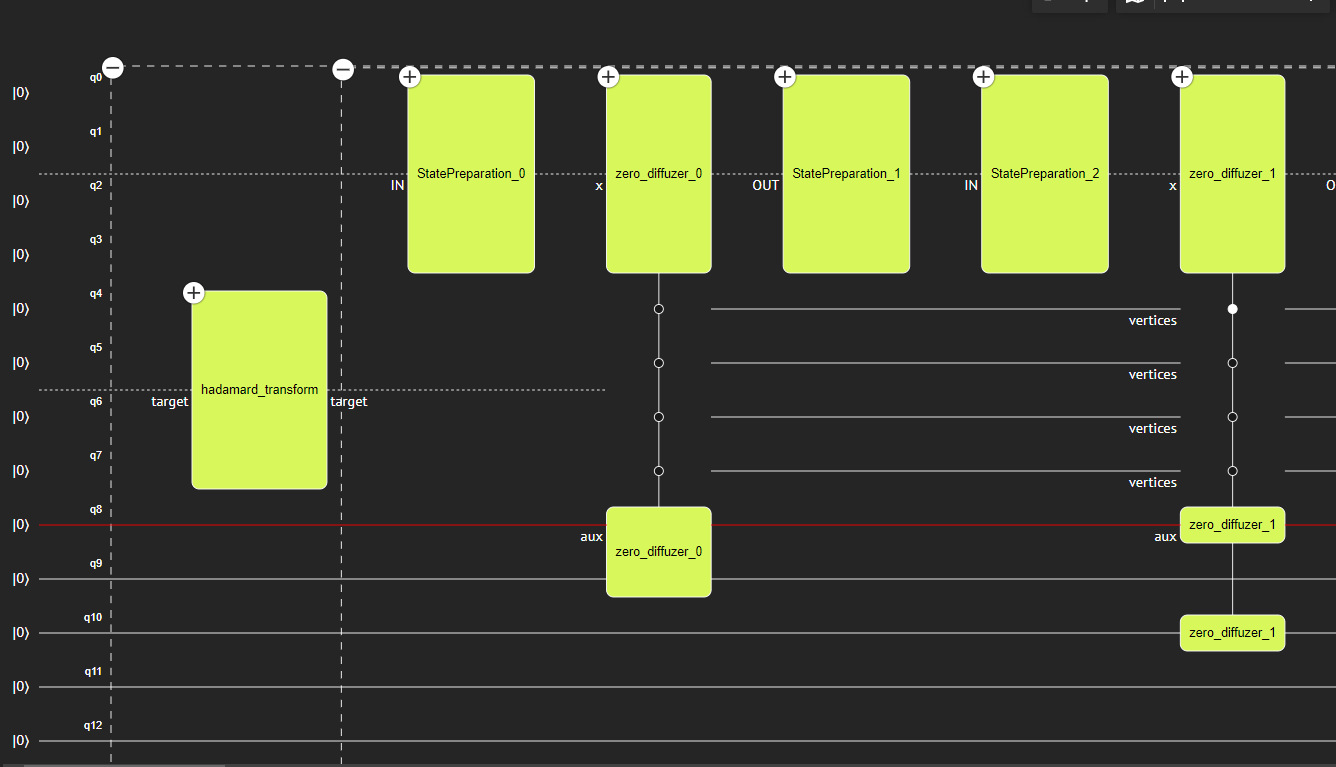

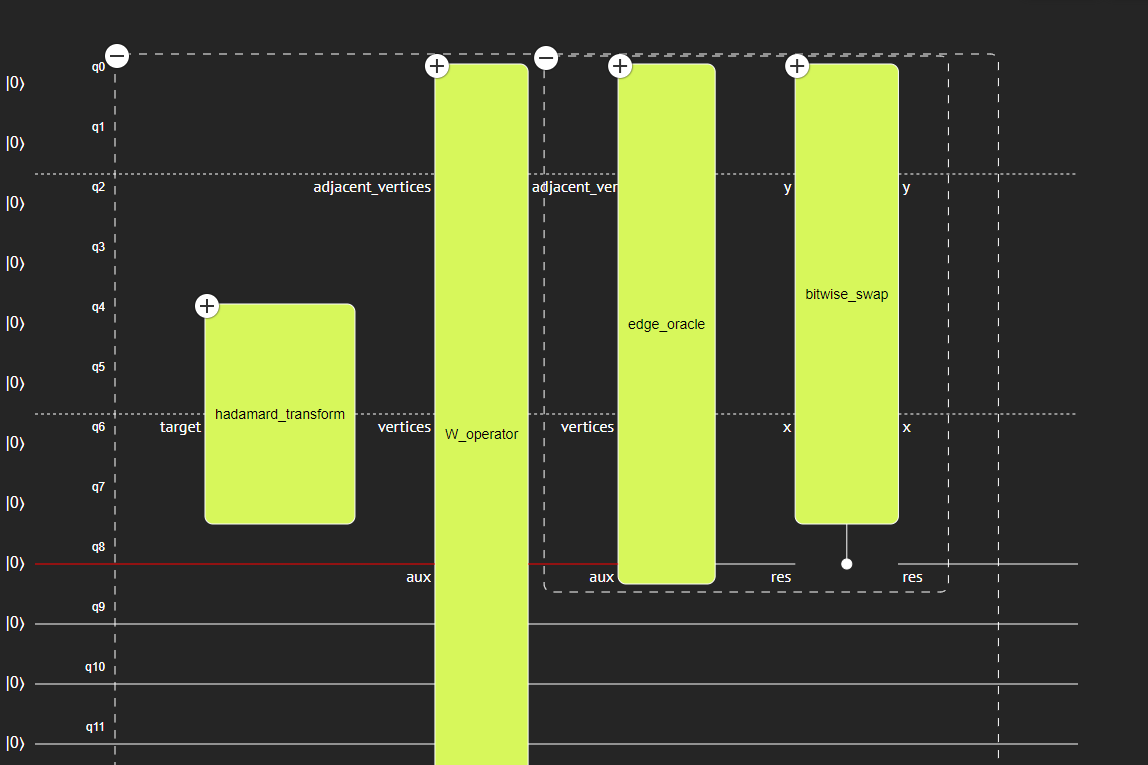

For a sufficient number of shots (12000), we obtain a histogram that approximates the uniform distribution quite well. 

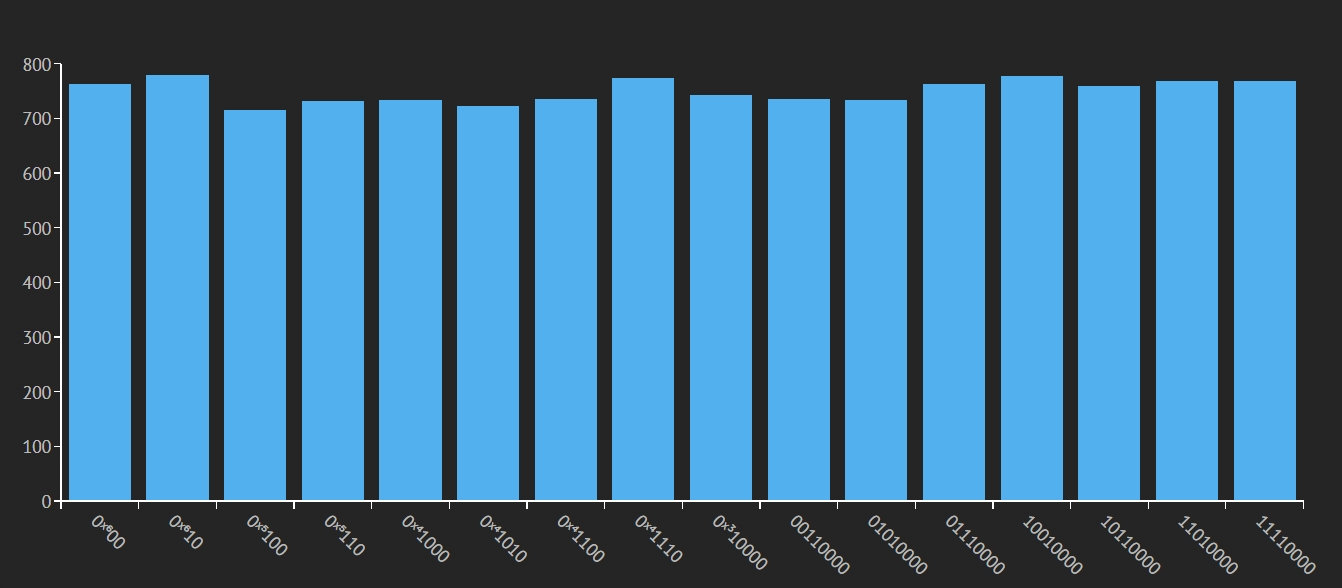